In [1]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, mean_squared_error
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_curve

FOLDER_PATH = "/home/juan/Work/Midterm project/splited/"
X_PATH = os.path.join(FOLDER_PATH, "X_data.npz")
Y_PATH = os.path.join(FOLDER_PATH, "Y_data.npz")
COLS_PATH = os.path.join(FOLDER_PATH, "feature_names.json")

# --- PART 1: DATA PREPARATION (Run only if NPZ files don't exist) ---
if not os.path.exists(X_PATH) or not os.path.exists(Y_PATH):
    print("NPZ files not found. Starting processing of CSV files...")
    
    FILE_PATTERN = os.path.join(FOLDER_PATH, "processed_*.csv")
    files = sorted(glob.glob(FILE_PATTERN))
    print(f"Found {len(files)} processed files.")

    if len(files) == 0:
        raise FileNotFoundError("No 'processed_*.csv' files found in the directory.")

    # 1. Read first file to determine column structure
    print("Reading headers from first file...")
    first_df = pd.read_csv(files[0], nrows=5)
    cols = first_df.columns
    x_cols = [c for c in cols if c.startswith("x ")]
    y_cols = [c for c in cols if c.startswith("y ")]
    
    # Save feature names for later use
    with open(COLS_PATH, 'w') as f:
        json.dump(x_cols, f)

    print(f"Detected {len(x_cols)} Features and {len(y_cols)} Targets.")

    X_list = []
    Y_list = []

    # 2. Loop through all files and convert to Sparse
    for f in files:
        print(f"Converting: {os.path.basename(f)}")
        df = pd.read_csv(f)
        
        x_data = df[x_cols].fillna(0).values.astype(np.float32)
        y_data = df[y_cols].fillna(0).values.astype(np.float32)
        
        X_list.append(sparse.csr_matrix(x_data))
        Y_list.append(sparse.csr_matrix(y_data))
        
        del df, x_data, y_data # Free RAM

    # 3. Stack and Save
    print("Stacking matrices...")
    X_final = sparse.vstack(X_list)
    Y_final = sparse.vstack(Y_list)

    print(f"Saving to {FOLDER_PATH}...")
    sparse.save_npz(X_PATH, X_final)
    sparse.save_npz(Y_PATH, Y_final)
    print("Processing complete.")

else:
    print("Found existing NPZ files. Skipping CSV processing.")

# --- PART 2: LOAD DATA & PREPARE FOR MODELING ---
print("Loading Data from disk...")
X = sparse.load_npz(X_PATH)
Y = sparse.load_npz(Y_PATH)

print(f"Input Shape: {X.shape}")
print(f"Target Shape: {Y.shape}") 

# 1. Select Target (Most Frequent Reaction for simple stats, though we use all for training)
col_sums = np.array(Y.sum(axis=0)).flatten()
target_idx = np.argmax(col_sums)
y_target = Y[:, target_idx].toarray().ravel()

print(f"Target Index selected: {target_idx}")
print(f"Positive Cases: {int(sum(y_target))} / {len(y_target)}")

# 2. Calculate Class Weight
pos_count = sum(y_target)
neg_count = len(y_target) - pos_count
scale_weight = neg_count / (pos_count + 1e-5)
print(f"Calculated Class Weight (neg/pos): {scale_weight:.2f}")

# 3. Train/Test Split indices
print("Splitting data...")
# We use indices to split to avoid densifying the huge matrix
indices = np.arange(X.shape[0])
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

print("Data Split Complete.")

Found existing NPZ files. Skipping CSV processing.
Loading Data from disk...
Input Shape: (661271, 5286)
Target Shape: (661271, 10488)
Target Index selected: 4309
Positive Cases: 52505 / 661271
Calculated Class Weight (neg/pos): 11.59
Splitting data...
Data Split Complete.


In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import scipy.sparse as sparse
from torch_geometric.data import HeteroData
# Note: We import HANConv instead of SAGEConv
from torch_geometric.nn import HANConv, Linear
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Update these paths to match your actual file locations if needed
FOLDER_PATH = "/home/juan/Work/Midterm project/splited/"
X_PATH = os.path.join(FOLDER_PATH, "X_data.npz")
Y_PATH = os.path.join(FOLDER_PATH, "Y_data.npz")

print("Loading Data...")
X = sparse.load_npz(X_PATH)
Y = sparse.load_npz(Y_PATH)

# Get dimensions
num_patients = X.shape[0]
num_input_features = X.shape[1] # Treated as 'Drug' nodes
num_reactions = Y.shape[1]      # Treated as 'Reaction' nodes

print(f"Patients: {num_patients}")
print(f"Input Nodes (Drugs/Feats): {num_input_features}")
print(f"Output Nodes (Reactions): {num_reactions}")

# Split data
indices = np.arange(num_patients)
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

Loading Data...
Patients: 661271
Input Nodes (Drugs/Feats): 5286
Output Nodes (Reactions): 10488


In [4]:
class HeteroGraphDataset(Dataset):
    def __init__(self, X, Y, indices, num_input_nodes, num_output_nodes):
        self.X = X
        self.Y = Y
        self.indices = indices
        self.num_input_nodes = num_input_nodes
        self.num_output_nodes = num_output_nodes

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.indices[idx]

def graph_collate_fn(batch_indices):
    batch_indices = sorted(batch_indices)
    
    x_sub = X[batch_indices]
    y_sub = Y[batch_indices] 
    
    batch_size = len(batch_indices)

    rows_d, cols_d = x_sub.nonzero()
    edge_index_drug = torch.stack([torch.from_numpy(rows_d), torch.from_numpy(cols_d)]).long()
    
    rows_r, cols_r = y_sub.nonzero()
    edge_index_react = torch.stack([torch.from_numpy(rows_r), torch.from_numpy(cols_r)]).long()
    
    data = HeteroData()
    
    # Nodes
    data['patient'].x = torch.ones((batch_size, 1), dtype=torch.float)
    data['patient'].num_nodes = batch_size
    
    data['drug'].num_nodes = num_input_features
    data['reaction'].num_nodes = num_reactions
    
    # Edges
    data['patient', 'takes', 'drug'].edge_index = edge_index_drug
    data['patient', 'has_reaction', 'reaction'].edge_index = edge_index_react
    
    # Reverse Edges for message passing
    data['drug', 'taken_by', 'patient'].edge_index = torch.flip(edge_index_drug, [0])
    data['reaction', 'reaction_in', 'patient'].edge_index = torch.flip(edge_index_react, [0])
    
    return data

batch_size = 1024 
train_ds = HeteroGraphDataset(X, Y, train_idx, num_input_features, num_reactions)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=graph_collate_fn, num_workers=0)

In [30]:
train_ds

In [5]:
class HeteroHAN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, metadata, num_heads=2):
        super().__init__()
        # HANConv explicitly uses meta-paths (auto-detected from metadata)
        # It aggregates neighbors based on meta-paths like Patient-Drug-Patient
        self.han_conv1 = HANConv(in_channels=hidden_channels, out_channels=hidden_channels, 
                                 heads=num_heads, dropout=0.2, metadata=metadata)
        
        self.han_conv2 = HANConv(in_channels=hidden_channels, out_channels=out_channels, 
                                 heads=num_heads, dropout=0.2, metadata=metadata)

    def forward(self, x_dict, edge_index_dict):
        # 1. First HAN Layer
        x = self.han_conv1(x_dict, edge_index_dict)
        x = {k: v.relu() for k, v in x.items()}
        
        # 2. Second HAN Layer
        x = self.han_conv2(x, edge_index_dict)
        return x

# Define Metadata (Graph Schema)
metadata = (
    ['patient', 'drug', 'reaction'],
    [('patient', 'takes', 'drug'), 
     ('drug', 'taken_by', 'patient'),
     ('patient', 'has_reaction', 'reaction'),
     ('reaction', 'reaction_in', 'patient')]
)

# Initialize Model
# We set hidden_channels=64. HANConv handles multiple heads internally.
model = HeteroHAN(hidden_channels=64, out_channels=64, metadata=metadata, num_heads=2).to(device)

# Embeddings/Projections (Same as before)
drug_emb = torch.nn.Embedding(num_input_features + 1, 64).to(device)
react_emb = torch.nn.Embedding(num_reactions + 1, 64).to(device)
patient_lin = Linear(1, 64).to(device)

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(drug_emb.parameters()) + list(react_emb.parameters()) + list(patient_lin.parameters()), 
    lr=0.01
)

print("HeteroHAN Model Initialized.")

HeteroHAN Model Initialized.


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
THRESHOLD = 0.8 
print(f"Training with Threshold: {THRESHOLD}")

history = {
    'train_loss': [],
    'train_prec': [],
    'train_rec': [],
    'train_f1': []
}

for epoch in range(1, 11): # 10 Epochs
    model.train()
    total_loss = 0
    total_examples = 0
    total_tp, total_fp, total_fn = 0, 0, 0
    
    for i, batch in enumerate(train_loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # 1. Prepare Inputs
        # Project all nodes to the same 64-dim space before HANConv
        x_dict = {
            'patient': patient_lin(batch['patient'].x),
            'drug': drug_emb(torch.arange(num_input_features, device=device)),
            'reaction': react_emb(torch.arange(num_reactions, device=device))
        }
        
        # 2. Forward Pass (HAN)
        out = model(x_dict, batch.edge_index_dict)
        
        # 3. Get Scores (Dot Product)
        edge_index = batch['patient', 'has_reaction', 'reaction'].edge_index
        if edge_index.numel() == 0: continue

        src_emb = out['patient'][edge_index[0]]
        dst_emb = out['reaction'][edge_index[1]]
        
        pos_score = (src_emb * dst_emb).sum(dim=-1)
        
        # Negative Sampling
        neg_dst_idx = torch.randint(0, num_reactions, (len(pos_score),), device=device)
        neg_dst_emb = out['reaction'][neg_dst_idx]
        neg_score = (src_emb * neg_dst_emb).sum(dim=-1)
        
        # 4. Calculate Loss
        scores = torch.cat([pos_score, neg_score])
        labels = torch.cat([torch.ones_like(pos_score), torch.zeros_like(neg_score)])
        loss = F.binary_cross_entropy_with_logits(scores, labels)
        
        loss.backward()
        optimizer.step()
        
        # 5. Metrics
        with torch.no_grad():
            pos_probs = pos_score.sigmoid()
            neg_probs = neg_score.sigmoid()
            
            tp = (pos_probs > THRESHOLD).sum().item()
            fn = (pos_probs <= THRESHOLD).sum().item()
            fp = (neg_probs > THRESHOLD).sum().item()
            
            total_tp += tp
            total_fp += fp
            total_fn += fn
            total_loss += loss.item() * batch['patient'].num_nodes
            total_examples += batch['patient'].num_nodes

    # --- End of Epoch Stats ---
    epsilon = 1e-9
    precision = total_tp / (total_tp + total_fp + epsilon)
    recall = total_tp / (total_tp + total_fn + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    avg_loss = total_loss / total_examples
    
    history['train_loss'].append(avg_loss)
    history['train_f1'].append(f1)
    
    print(f"Epoch {epoch} | Loss: {avg_loss:.4f} | Prec: {precision:.4f} | Rec: {recall:.4f} | F1: {f1:.4f}")

Training with Threshold: 0.8
Epoch 1 | Loss: 0.4434 | Prec: 0.9507 | Rec: 0.8866 | F1: 0.9176
Epoch 2 | Loss: 0.4361 | Prec: 0.9576 | Rec: 0.9000 | F1: 0.9279
Epoch 3 | Loss: 0.4334 | Prec: 0.9595 | Rec: 0.9067 | F1: 0.9323
Epoch 4 | Loss: 0.4328 | Prec: 0.9597 | Rec: 0.9098 | F1: 0.9341
Epoch 5 | Loss: 0.4335 | Prec: 0.9594 | Rec: 0.9061 | F1: 0.9320
Epoch 6 | Loss: 0.4322 | Prec: 0.9598 | Rec: 0.9098 | F1: 0.9342
Epoch 7 | Loss: 0.4316 | Prec: 0.9601 | Rec: 0.9106 | F1: 0.9347
Epoch 8 | Loss: 0.4313 | Prec: 0.9607 | Rec: 0.9105 | F1: 0.9349
Epoch 9 | Loss: 0.4314 | Prec: 0.9604 | Rec: 0.9102 | F1: 0.9346
Epoch 10 | Loss: 0.4312 | Prec: 0.9609 | Rec: 0.9098 | F1: 0.9347


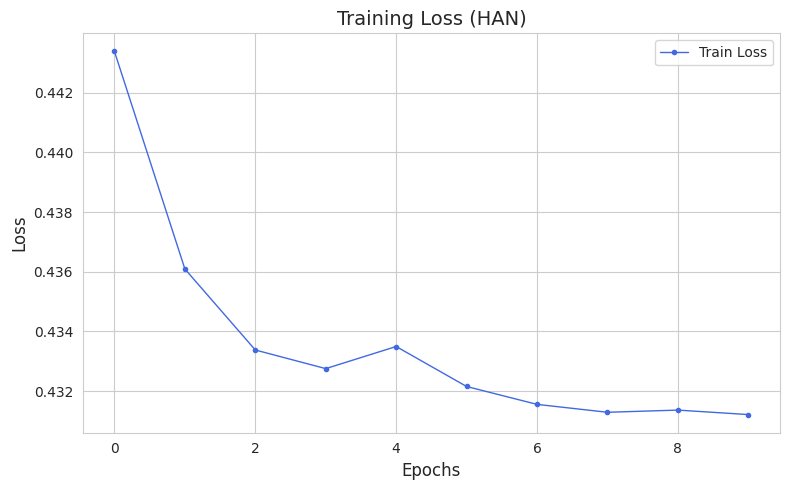

In [7]:
# Set plot style
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

# --- Plot 1: Training Loss ---
# plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], marker='.', color='royalblue', linewidth=1, label='Train Loss')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training Loss (HAN)", fontsize=14)
plt.legend()

plt.tight_layout()
plt.savefig('train_loss.png') 
plt.show()

In [8]:
# Create Test Loader
test_ds = HeteroGraphDataset(X, Y, test_idx, num_input_features, num_reactions)
test_loader = DataLoader(test_ds, batch_size=1024, shuffle=False, collate_fn=graph_collate_fn, num_workers=0)

model.eval()
total_test_tp = 0
total_test_fp = 0
total_test_fn = 0

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        
        # 1. Forward Pass
        x_dict = {
            'patient': patient_lin(batch['patient'].x),
            'drug': drug_emb(torch.arange(num_input_features, device=device)),
            'reaction': react_emb(torch.arange(num_reactions, device=device))
        }
        
        out = model(x_dict, batch.edge_index_dict)
        
        edge_index = batch['patient', 'has_reaction', 'reaction'].edge_index
        if edge_index.numel() == 0: continue

        src_emb = out['patient'][edge_index[0]]
        dst_emb = out['reaction'][edge_index[1]]
        
        pos_score = (src_emb * dst_emb).sum(dim=-1)
        
        neg_dst_idx = torch.randint(0, num_reactions, (len(pos_score),), device=device)
        neg_dst_emb = out['reaction'][neg_dst_idx]
        neg_score = (src_emb * neg_dst_emb).sum(dim=-1)
        
        # Metrics using raw logits > 0 (equivalent to prob > 0.5)
        # You can use THRESHOLD here as well if you want strict alignment with training
        tp = (pos_score > 0).sum().item()
        fn = (pos_score <= 0).sum().item()
        fp = (neg_score > 0).sum().item() 
        
        total_test_tp += tp
        total_test_fp += fp
        total_test_fn += fn

epsilon = 1e-9
test_precision = total_test_tp / (total_test_tp + total_test_fp + epsilon)
test_recall = total_test_tp / (total_test_tp + total_test_fn + epsilon)
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall + epsilon)

print(f"   Precision: {test_precision:.4f}")
print(f"   Recall:    {test_recall:.4f}")
print(f"   F1-Score:  {test_f1:.4f}")

   Precision: 0.9397
   Recall:    0.9558
   F1-Score:  0.9477


In [9]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

model.eval()

all_y_true = []
all_y_scores = []

all_y_preds = []

print("Starting Evaluation...")

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        
        # 1. Prepare Inputs (Same as training)
        x_dict = {
            'patient': patient_lin(batch['patient'].x),
            'drug': drug_emb(torch.arange(num_input_features, device=device)),
            'reaction': react_emb(torch.arange(num_reactions, device=device))
        }
        
        # 2. Forward Pass to get contextualized embeddings
        out = model(x_dict, batch.edge_index_dict)
        
        # 3. Get Scores for Positive Edges (Actual Links)
        edge_index = batch['patient', 'has_reaction', 'reaction'].edge_index
        if edge_index.numel() == 0: continue

        src_emb = out['patient'][edge_index[0]]
        dst_emb = out['reaction'][edge_index[1]]
        
        # Dot product for positive scores
        pos_scores = (src_emb * dst_emb).sum(dim=-1)
        
        # 4. Get Scores for Negative Edges (Fake Links)
        # Sample random negatives equal to the number of positives
        neg_dst_idx = torch.randint(0, num_reactions, (len(pos_scores),), device=device)
        neg_dst_emb = out['reaction'][neg_dst_idx]
        neg_scores = (src_emb * neg_dst_emb).sum(dim=-1)
        
        # 5. Apply Sigmoid to get probabilities (0 to 1)
        pos_probs = pos_scores.sigmoid()
        neg_probs = neg_scores.sigmoid()
        
        # 6. Collect Data
        # Positive samples have label 1, Negative samples have label 0
        batch_scores = torch.cat([pos_probs, neg_probs]).cpu().numpy()
        batch_labels = torch.cat([torch.ones_like(pos_probs), torch.zeros_like(neg_probs)]).cpu().numpy()
        
        all_y_scores.extend(batch_scores)
        all_y_true.extend(batch_labels)
        
        # Optional: Threshold for binary classification metrics
        all_y_preds.extend((batch_scores > 0.5).astype(int))

# --- Calculate Final Metrics ---
roc_auc = roc_auc_score(all_y_true, all_y_scores)
precision = precision_score(all_y_true, all_y_preds)
recall = recall_score(all_y_true, all_y_preds)
f1 = f1_score(all_y_true, all_y_preds)

print("-" * 30)
print(f"Final Test Metrics:")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("-" * 30)

Starting Evaluation...
------------------------------
Final Test Metrics:
ROC-AUC:   0.9633
Precision: 0.9388
Recall:    0.9558
F1-Score:  0.9472
------------------------------


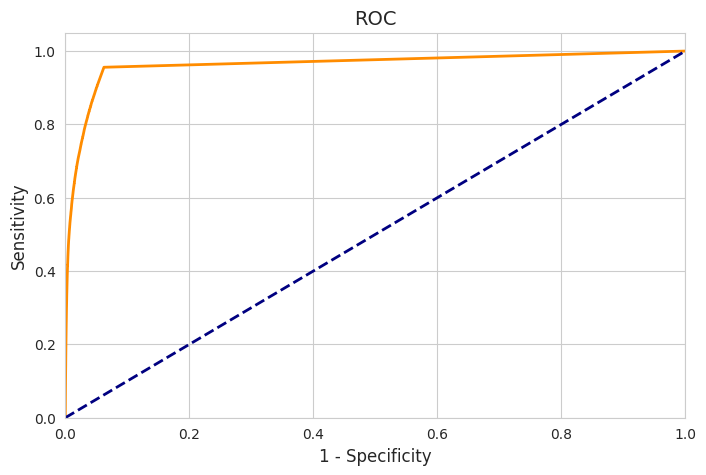

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1. Compute ROC curve and ROC area
# all_y_true: Ground truth (0 or 1)
# all_y_scores: Sigmoid probabilities (0.0 to 1.0)
fpr, tpr, thresholds = roc_curve(all_y_true, all_y_scores)
roc_auc = auc(fpr, tpr)

# 2. Plot ROC Curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')

# Plot the "Random Guess" line (diagonal)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity', fontsize=12)
plt.ylabel('Sensitivity', fontsize=12)
plt.title("ROC", fontsize=14)
plt.grid(True)

# Save and Show
plt.savefig('roc_curve.png')
plt.show()

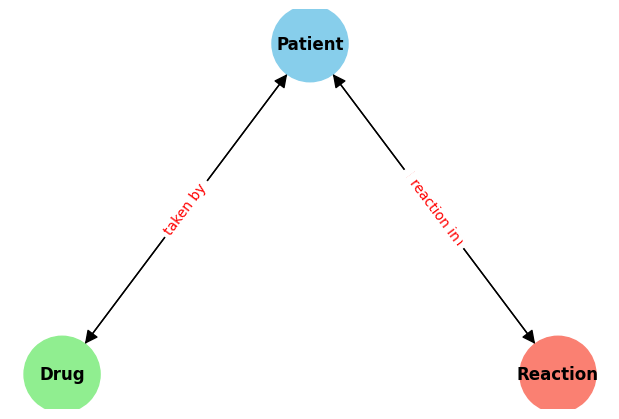

In [27]:
def visualize_schema():
    G_schema = nx.DiGraph()
    
    # Add Node Types (The "Tables")
    G_schema.add_node("Patient", color='skyblue')
    G_schema.add_node("Drug", color='lightgreen')
    G_schema.add_node("Reaction", color='salmon')
    
    # Add Edge Types (The "Relations")
    G_schema.add_edge("Patient", "Drug", label="takes")
    G_schema.add_edge("Drug", "Patient", label="taken by")
    G_schema.add_edge("Patient", "Reaction", label="has_reaction")
    G_schema.add_edge("Reaction", "Patient", label="reaction in")
    
    plt.figure(figsize=(6, 4))
    pos = {
        'Patient': (0.5, 0.5),
        'Drug': (0.2, 0.2),
        'Reaction': (0.8, 0.2)
    }
    
    node_colors = [nx.get_node_attributes(G_schema, 'color')[n] for n in G_schema.nodes()]
    
    nx.draw(G_schema, pos, with_labels=True, node_color=node_colors, 
            node_size=3000, font_weight='bold', arrowsize=20, arrows=True)
    
    edge_labels = nx.get_edge_attributes(G_schema, 'label')
    nx.draw_networkx_edge_labels(G_schema, pos, edge_labels=edge_labels, font_color='red')
    
    plt.axis('off')
    plt.show()

visualize_schema()

Sampling 1000 patients to visualize global density...
Graph stats: 2485 nodes, 7373 edges


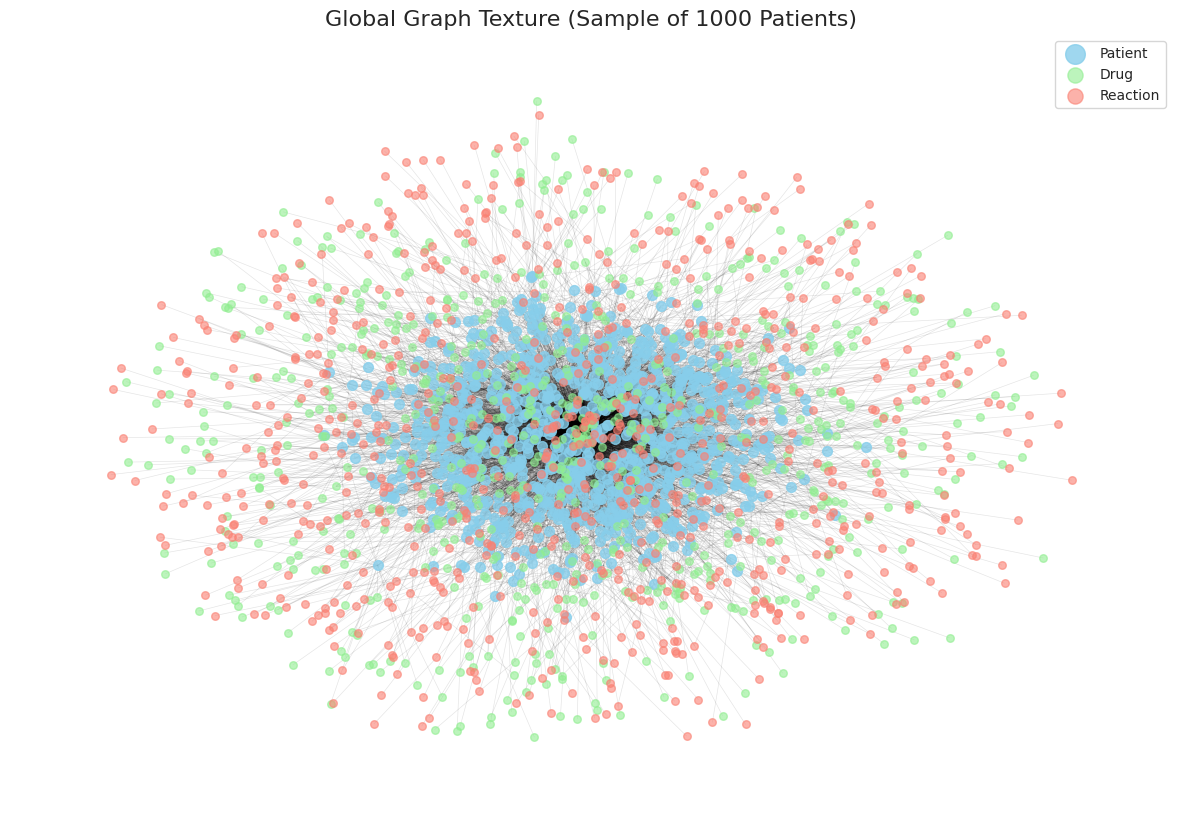

In [29]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_large_graph_sample(X_sparse, Y_sparse, num_samples=100):
    """
    Visualizes a large random subset of the graph to represent the whole structure.
    """
    print(f"Sampling {num_samples} patients to visualize global density...")
    
    # 1. Sample Random Indices
    total_patients = X_sparse.shape[0]
    indices = np.random.choice(total_patients, num_samples, replace=False)
    indices = np.sort(indices) # Sorting helps slicing
    
    # 2. Extract Sub-Matrices
    x_sub = X_sparse[indices]
    y_sub = Y_sparse[indices]
    
    # 3. Build Graph
    G = nx.Graph()
    
    # Add Patient Nodes
    # We use 'P_idx' to store original ID, but node ID in graph is distinct
    for i, real_idx in enumerate(indices):
        G.add_node(f"P_{i}", color='skyblue', size=50, type='patient')
    
    # Add Drug Edges
    # x_sub is (samples, features)
    rows, cols = x_sub.nonzero()
    unique_drugs = set()
    for r, c in zip(rows, cols):
        drug_node = f"D_{c}"
        unique_drugs.add(drug_node)
        G.add_edge(f"P_{r}", drug_node, weight=1)
        
    # Add Drug Nodes (only those connected to our sample)
    for d in unique_drugs:
        G.add_node(d, color='lightgreen', size=30, type='drug')

    # Add Reaction Edges
    rows_r, cols_r = y_sub.nonzero()
    unique_reacts = set()
    for r, c in zip(rows_r, cols_r):
        react_node = f"R_{c}"
        unique_reacts.add(react_node)
        G.add_edge(f"P_{r}", react_node, weight=1)
        
    # Add Reaction Nodes
    for r_node in unique_reacts:
        G.add_node(r_node, color='salmon', size=30, type='reaction')

    print(f"Graph stats: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    # 4. Plotting
    plt.figure(figsize=(15, 10))
    
    # Force-directed layout (spring_layout) for a "natural" cluster look
    pos = nx.spring_layout(G, k=0.15, iterations=50, seed=42)
    
    # Get node lists by type
    patients = [n for n, d in G.nodes(data=True) if d['type'] == 'patient']
    drugs = [n for n, d in G.nodes(data=True) if d['type'] == 'drug']
    reactions = [n for n, d in G.nodes(data=True) if d['type'] == 'reaction']
    
    # Draw Nodes
    nx.draw_networkx_nodes(G, pos, nodelist=patients, node_color='skyblue', node_size=50, alpha=0.8, label='Patient')
    nx.draw_networkx_nodes(G, pos, nodelist=drugs, node_color='lightgreen', node_size=30, alpha=0.6, label='Drug')
    nx.draw_networkx_nodes(G, pos, nodelist=reactions, node_color='salmon', node_size=30, alpha=0.6, label='Reaction')
    
    # Draw Edges (Thin lines for clarity)
    nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.5)
    
    plt.title(f"Global Graph Texture (Sample of {num_samples} Patients)", fontsize=16)
    plt.legend(scatterpoints=1, markerscale=2)
    plt.axis('off')
    plt.show()

# Run visualization with 150 patients (Adjust number if it's too slow)
visualize_large_graph_sample(X, Y, num_samples=1000)